# Network introduction 
Main parts of the course:
1. networks definitions and network measures 
2. networks in time 
3. processes on networks 
4. networks from data

This notebook was inspired from:
* Bruno Gonçalves / Data4Sci: https://github.com/DataForScience/Networks
* Michael Szell data course
* Big data course from 2019 Marc and Liubov https://github.com/Big-data-course-CRI/materials_big_data_cri_2019

In [10]:

!pip install networkx 
import networkx as nx


In [11]:
from collections import Counter
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt 

# 1. Network definition and generation 
We can use edge list for generation of a network. 

Let us start by defining a list of edges. This will give us our first "dataset" to work with

In [12]:
edge_list = [
    ('A', 'B'),
    ('A', 'C'),
    ('A', 'E'),
    ('B', 'C'),
    ('C', 'D'),
    ('C', 'E'),
    ('D', 'E')]

This is a particularly useful representation as many datasets are distributed in this (or a closely related) format. From this list, we can easily measure the number of edges that constitute our network. It's main limitations are that it has no way to explictly take into account disconnected nodes (it only accounts for nodes that are part of edges) and no indication on whether it is directed or not.

In [13]:
number_edges = len(edge_list)
print(number_edges)

7


To get the number of node is a bit trickier. We must go edge by edge and keep track of all new nodes. For efficiency, we use a set to automatically remove duplicates

In [4]:
nodes = set()

for edge in edge_list:
    nodes.update(edge)
    
number_nodes = len(nodes)
print(number_nodes)

5


Now we know that we have 5 nodes and 7 edges in our network. The node ids are:

In [5]:
nodes

{'A', 'B', 'C', 'D', 'E'}

Using Adjacency List for network generation.

**Important:** you may generate and build network from your data using adjacency list. 

A closely related data structure to the edge list is the adjacency list. In this formulation, we use a dictionary to map each node to its set of neighbors

In [7]:
adj_list = {}

for node_i, node_j in edge_list:
    if node_i not in adj_list:
        adj_list[node_i] = set()
    
    adj_list[node_i].add(node_j)

Our adjaceny list is then:

In [10]:
pprint(adj_list)

{'A': {'E', 'C', 'B'}, 'B': {'C'}, 'C': {'E', 'D'}, 'D': {'E'}}


In this approach we inherently assumed that our network is directed (or, equivalently, that both edge directions are present in the data). To generate an undirected version we must make a simple modification to our code to manually add the opposite direction edge

In [11]:
adj_list = {}

for node_i, node_j in edge_list:
    if node_i not in adj_list:
        adj_list[node_i] = set() # 'set' is used to prevent accidental multiple edges
    
    adj_list[node_i].add(node_j)
    
    # Manually add the opposite direction edge
    if node_j not in adj_list:
        adj_list[node_j] = set()
    
    adj_list[node_j].add(node_i)

The undirected adjacency list represenation is then:

In [12]:
pprint(adj_list)

{'A': {'E', 'C', 'B'},
 'B': {'A', 'C'},
 'C': {'A', 'E', 'B', 'D'},
 'D': {'E', 'C'},
 'E': {'A', 'C', 'D'}}


# Adjacency Matrix
Generation of a network using matrix. 

We now move on to generating an Adjacency Matrix view of the network. For this we must have two things: 

- the number of nodes in the network
- A mapping between the original node ids and a sequential numerical ID

We start by building out the numerical ID mapping. As we do, we get the number of nodes for free

In [14]:
node_id = {}
node_count = 0

for node_i, node_j in edge_list:
    if node_i not in node_id:
        node_id[node_i] = node_count
        node_count += 1
    
    # Make sure we have an id for both nodes
    # This is necessary, irregardless of whether the network is directed or undirected
    if node_j not in node_id:
        node_id[node_j] = node_count
        node_count += 1

We can check that each of the original node ids is correctly mapped to a sequential number

In [15]:
node_id

{'A': 0, 'B': 1, 'C': 2, 'E': 3, 'D': 4}

Finally, we are ready to build our adjacency matrix. We start by declaring the data structurewe will use

In [16]:
adj_matrix = np.zeros((node_count, node_count), dtype='int')

And we can now populate the matrix entries. For generality, we'll include a flag to control wether or not the graph is directed. As we don't have any weights associated with our edges, we assign to each of them a value of 1.

In [18]:
is_directed = False

for node_i, node_j in edge_list:    
    # Get the correct node ids
    node_i = node_id[node_i]
    node_j = node_id[node_j]
    
    adj_matrix[node_i, node_j] = 1 # Unweighted network

    if not is_directed:
        adj_matrix[node_j, node_i] = 1 # Undirected networks

Our Adjacency Matrix is then:

In [19]:
adj_matrix

array([[0, 1, 1, 1, 0],
       [1, 0, 1, 0, 0],
       [1, 1, 0, 1, 1],
       [1, 0, 1, 0, 1],
       [0, 0, 1, 1, 0]])

As we can see, the Adjacency matrix representation is very wasteful, using 25 values to store a 7 (14) edge network plus 5 dictionary entries for the id mappings.

# Adjacency Dictionary

The final graph representation we will explore is the Adjacency Dict. This is a generalization of the Adjacency List covered above that is a bit more flexible and is able to accuratly account for diconnected nodes, weights, etc. For this we will need two datastructures, one to store node information and one for edges. For the sake of flexbility, we will use dicts for both.

In [20]:
nodes = {}
edges = {}
is_directed = False

And we can now populate them from our original edge_list

In [22]:
for node_i, node_j in edge_list:
    if node_i not in nodes:
        nodes[node_i] = {}
        edges[node_i] = {}
        
    if node_j not in nodes:
        nodes[node_j] = {}
        
        if not is_directed:
            edges[node_j] = {}
    
    edges[node_i][node_j] = {}
    
    if not is_directed:
        edges[node_j][node_i] = {}

Our set of nodes is:

In [23]:
nodes

{'A': {}, 'B': {}, 'C': {}, 'E': {}, 'D': {}}

Where we chose to use dictinaries to allow for the storage of node attributes. Further, our edges are now:

In [24]:
edges

{'A': {'B': {}, 'C': {}, 'E': {}},
 'B': {'A': {}, 'C': {}},
 'C': {'A': {}, 'B': {}, 'D': {}, 'E': {}},
 'E': {'A': {}, 'C': {}, 'D': {}},
 'D': {'C': {}, 'E': {}}}

Where we once again opted to associate a dictionary to each edge. This gives us the ability to associate edge information (such as weights, etc) to each node.

As we can see, this is the most flexible representation and can be easily converted to one of the other representations if necessary so we will use this approach for the rest of the lecture.

## 1. Random networks generation 

How can we generate networks, which are general enough? 
Using network classes of 
1. deterministic 
2. random networks 


## Classes of networks
Networkx classes
https://networkx.github.io/documentation/stable/reference/generators.html 

Other pre-assigned network classes return:

1. balanced_tree(r, h[, create_using]), the perfectly balanced r-ary tree of height h.
2. barbell_graph(m1, m2[, create_using]), the Barbell Graph: two complete graphs connected by a path.
3. binomial_tree(n), the Binomial Tree of order n.
4. complete_graph(n[, create_using]), the complete graph K_n with n nodes.
5. complete_multipartite_graph(*subset_sizes), the complete multipartite graph with the specified subset sizes.
6. circular_ladder_graph(n[, create_using]), the circular ladder graph \(CL_n\) of length n.
7. circulant_graph(n, offsets[, create_using]), the circulant graph \(Ci_n(x_1, x_2, ..., x_m)\) with \(n\) vertices.
8. cycle_graph(n[, create_using]), the cycle graph \(C_n\) of cyclically connected nodes.
9. dorogovtsev_goltsev_mendes_graph(n[, …]), the hierarchically constructed Dorogovtsev-Goltsev-Mendes graph.
10. empty_graph([n, create_using, default]), the empty graph with n nodes and zero edges.
11. full_rary_tree(r, n[, create_using]), a full r-ary tree of n vertices.
12. ladder_graph(n[, create_using]), the Ladder graph of length n.
13. lollipop_graph(m, n[, create_using]), the Lollipop Graph; K_m connected to P_n.
14. path_graph(n[, create_using]),  the Path graph P_n of linearly connected nodes.
15. star_graph(n[, create_using]), the star graph
16. trivial_graph([create_using]), the Trivial graph with one node (with label 0) and no edges.
17. turan_graph(n, r), the Turan Graph
18. wheel_graph(n[, create_using]), the wheel graph



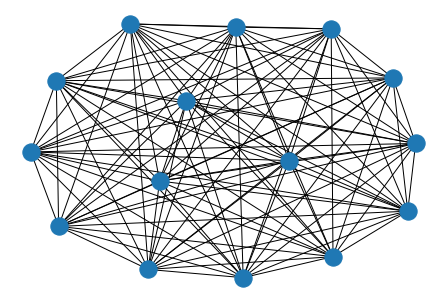

In [14]:
# 1. Generate a network
N=15
G = nx.complete_graph(N)

# 2. Draw using the preassigned layout
nx.draw(G)



## 1. Network measures

Centrality measures for a given network are described in https://en.wikipedia.org/wiki/Centrality 

Examples of possible local measures: 
1. `degree_centrality(G)`, the degree centrality for nodes.
2. `in_degree_centrality(G)`, the in-degree centrality for nodes.
3. `out_degree_centrality(G)`, the out-degree centrality for nodes
4. `betweenness_centrality(G)`, the shortest-path betweenness centrality for nodes. Betweenness centrality of a node v is the sum of the fraction of all-pairs shortest paths that pass through 
5. ` closeness_centrality(G)`, closeness centrality for nodes.  Closeness centrality  of a node u is the reciprocal of the sum of the shortest path distances from u to all n-1 other nodes
6. `eigenvector_centrality(G)`,  the eigenvector centrality for the graph G. Eigenvector centrality computes the centrality for a node based on the centrality of its neighbors. The eigenvector centrality for node i is $x$: $Ax = \lambda x$, where $\lambda$ is eigenvalue.

Other network measures are described in the networkx documentation https://networkx.github.io/documentation/stable/reference/generators.html 

## Example

<class 'dict'>
<class 'networkx.classes.reportviews.DegreeView'>
<class 'networkx.classes.reportviews.DegreeView'>
[3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1]


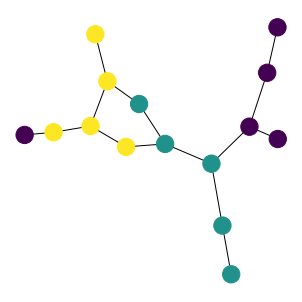

In [15]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Generate a network
n=10
G = nx.star_graph(n)

n = 15 
k = 2
p = 0.5
G = nx.watts_strogatz_graph(n, k, p)

# 2. Calculate measures for each node
deg = nx.degree_centrality(G) # gives a dictionary!!!
print(type(deg))
print(type(G.degree()))
print(type(G.degree))# gives 'networkx.classes.reportviews.DegreeView'
degree_sequence = sorted([d for n, d in G.degree()], reverse=True) # gives array of degree values
print(degree_sequence) 


# 3. Draw network with node colors defined by degree
plt.figure(figsize = (4, 4)) # set size of figure
node_color = degree_sequence # assign node colors
nx.draw(G, node_color = degree_sequence)



Adding additional information to plots. 

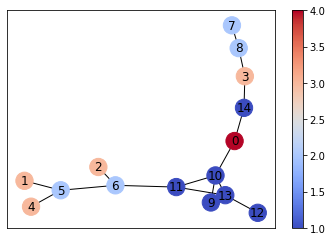

In [2]:
# we choose max and min degree for colorbars
vmin = min(degree_sequence) #.min() 
vmax = max(degree_sequence) # .max()
cmap = plt.cm.coolwarm

# we can choose another layouts: layout = nx.fruchterman_reingold_layout(G)


# we plot network with colorbars
nx.draw_networkx(G, node_color=degree_sequence,
                 cmap=cmap, vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm)



## Test yourself
Try to plot network measures for your favorite network.

1. For a network of your choice try to find network measure which is meaningful.
2. Visualise network measures for a network of your choise.

<class 'dict_values'>
dict_values([0.04697855750487329, 0.010428849902534112, 0.02880116959064327, 0.0809291747888239, 0.012280701754385967, 0.06148473034437946, 0.03723196881091617, 0.014814814814814815, 0.11228070175438598, 0.03879142300194932, 0.036712150747238464, 0.00760233918128655, 0.04692982456140351, 0.005068226120857699, 0.016439246263807664, 0.06993177387914229, 0.05748862897985705, 0.0034113060428849896, 0.1075211176088369, 0.006042884990253411])


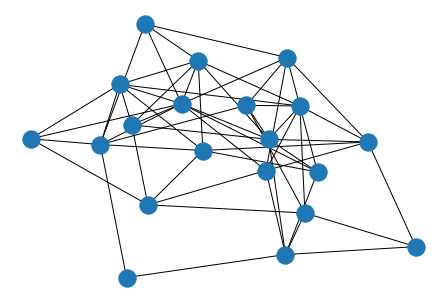

In [14]:
import networkx as nx

G_er = nx.erdos_renyi_graph(20, 0.3)
betw = nx.betweenness_centrality(G_er) #returns dictionary
print(type(betw.values()))
 
print(betw_sequence)
nx.draw(G_er)
#nx.draw_networkx(G_er) #node_color = betw_sequence
plt.show()


# Local network measures analysis. 
## Analysis of a network with local measures
We plot the distributions (sorted values of local measures) for `degree`, `clustering`, `betweenness` and other measures. Please use other setups for the plotting the histograms. 

The networks are quite messy and full of links, therefore we perform some simple network analysis on them.
The structure of G can be analyzed using various graph-theoretic functions such as: linear ones (degree), non-linear ones (betweenness etc.)

In [16]:
import numpy as np
import seaborn


def measures_for_network(G):
    # -*- coding: utf-8 -*-
    
    print('drawing measures for graph')
    plt.hist(list(nx.degree_centrality(G).values()))
    plt.xlabel('normalized degree') #np.max(nx.degree_centrality(G_roads).values())*
    plt.ylabel('frequency')
    plt.show()
    
    seaborn.distplot(list(nx.degree_centrality(G).values()), bins=20)
    plt.xlabel('normalized degree') #np.max(nx.degree_centrality(G_roads).values())*
    plt.ylabel('frequency')
    plt.show()    
    
    
    seaborn.distplot(list(nx.betweenness_centrality(G).values()), bins=20)#plt.hist(list(nx.betweenness_centrality(G).values()))
    plt.xlabel('betweenness')
    plt.ylabel('frequency')
    plt.show()
    
    
    
    seaborn.distplot(list(nx.clustering(G).values()), bins=20)
    plt.xlabel('clustering')
    plt.ylabel('frequency')
    plt.show()
    
    
    
    plt.hist(list(nx.closeness_centrality(G).values()))
    plt.xlabel('closeness')
    plt.ylabel('frequency')
    plt.show()
    
    print('calculating global measures')
    
    print('average neighbor degree', nx.average_degree_connectivity(G))
    
    print('average neighbor degree', nx.average_neighbor_degree(G))
    
    print('average clustering')
    avclus = nx.average_clustering(G)
    #print(avclus)
    
    
    
    components = nx.connected_components(G)
    #print('components', components)
    #[[1, 2, 3], ['spam']]
    
    
    nx.clustering(G)
    #{1: 0.0, 2: 0.0, 3: 0.0, 'spam': 0.0}
    
    
    nx.degree(G)
    #Functions that return node properties return dictionaries keyed by node label. {1: 2, 2: 1, 3: 1, 'spam': 0}



drawing measures for graph


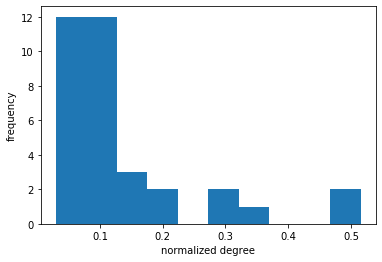

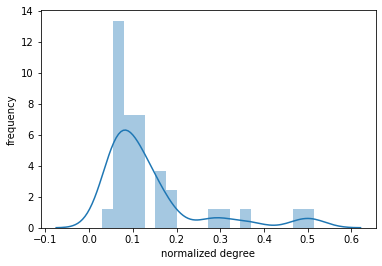

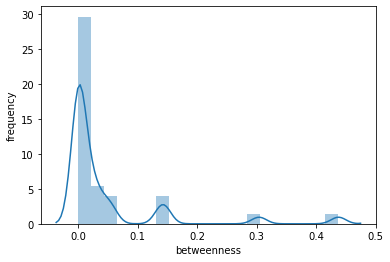

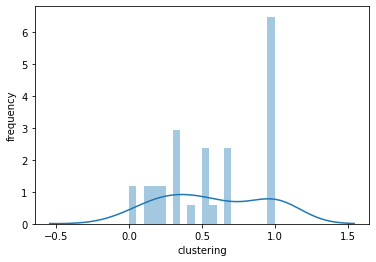

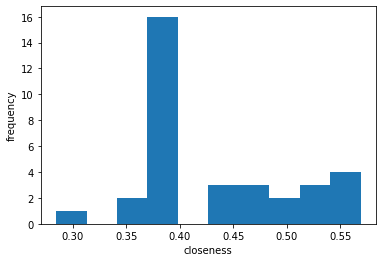

calculating global measures
average neighbor degree {16: 4.3125, 9: 5.777777777777778, 10: 6.6, 6: 8.333333333333334, 3: 8.222222222222221, 4: 8.541666666666666, 5: 10.466666666666667, 2: 12.409090909090908, 1: 16.0, 12: 5.083333333333333, 17: 3.823529411764706}
average neighbor degree {0: 4.3125, 1: 5.777777777777778, 2: 6.6, 3: 7.666666666666667, 4: 7.666666666666667, 5: 6.25, 6: 6.25, 7: 10.25, 8: 11.8, 9: 13.5, 10: 7.666666666666667, 11: 16.0, 12: 11.0, 13: 11.6, 14: 14.5, 15: 14.5, 16: 4.0, 17: 12.5, 18: 14.5, 19: 14.0, 20: 14.5, 21: 12.5, 22: 14.5, 23: 8.0, 24: 4.333333333333333, 25: 4.666666666666667, 26: 10.5, 27: 8.75, 28: 11.0, 29: 9.0, 30: 10.75, 31: 9.0, 32: 5.083333333333333, 33: 3.823529411764706}
average clustering
drawing measures for graph


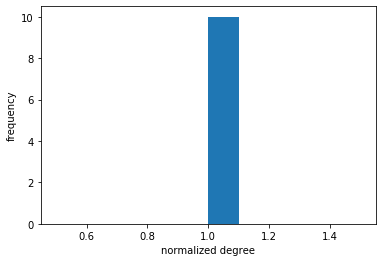

C:\Users\lyubo\Anaconda3\envs\default\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\lyubo\Anaconda3\envs\default\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


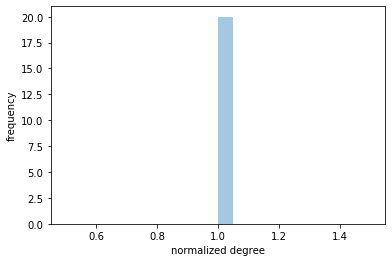

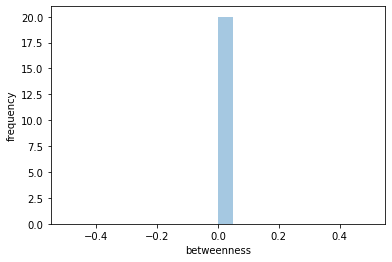

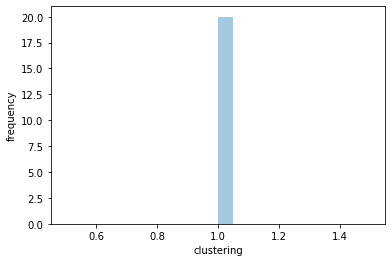

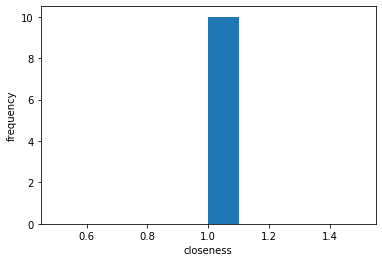

calculating global measures
average neighbor degree {9: 9.0}
average neighbor degree {0: 9.0, 1: 9.0, 2: 9.0, 3: 9.0, 4: 9.0, 5: 9.0, 6: 9.0, 7: 9.0, 8: 9.0, 9: 9.0}
average clustering


In [17]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from networkx.algorithms.community import greedy_modularity_communities

G = nx.karate_club_graph()

n = 10
Gc = nx.complete_graph(n)

measures_for_network(G)

measures_for_network(Gc)


## Community structure

The function `greedy_modularity_communities(G, weight=None)[source]`
finds communities in graph using Clauset-Newman-Moore greedy modularity maximization. This method currently supports the Graph class and does not consider edge weights.

In [18]:
from networkx.algorithms.community import greedy_modularity_communities

G = nx.karate_club_graph()
c = list(greedy_modularity_communities(G))
sorted(c[0])

[8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]

# 3. Processes on networks 

For more details on models in this notebook check B.Gonzales tutorials https://github.com/Dataforscience/networks

    [1] Temporal networks, Saramaki, Holme, https://arxiv.org/abs/1108.1780
    [2] Spreading in networks, Vespigniani, et al. https://arxiv.org/abs/1408.2701

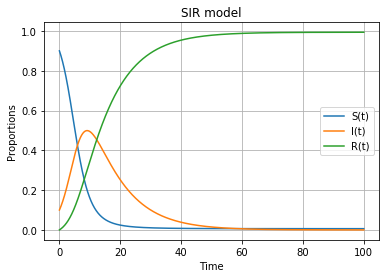

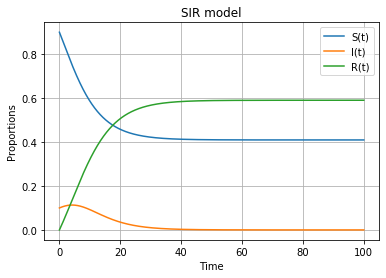

In [16]:
import scipy.integrate
import numpy
import matplotlib.pyplot as plt


def SIR_model(y,t,beta,mu):
    '''
    here we simulate SIR epidemics spreading model equations
    '''
    S,I,R=y
    dS_dt=-beta*S*I
    dI_dt=beta*S*I-mu*I
    dR_dt=mu*I
    return([dS_dt,dI_dt,dR_dt])

# initial parameters
S0=0.9
I0=0.1
R0=0.0

# parameters of spreading
beta=0.5
mu=0.1

t=numpy.linspace(0,100,10000)

solution=scipy.integrate.odeint(SIR_model,[S0,I0,R0],t,args=(beta,mu))
solution=numpy.array(solution)

plt.figure(figsize=[6,4])
plt.plot(t,solution[:,0],label="S(t)")
plt.plot(t,solution[:,1],label="I(t)")
plt.plot(t,solution[:,2],label="R(t)")
plt.grid()
plt.legend()
plt.xlabel("Time")
plt.ylabel("Proportions")
plt.title("SIR model")
plt.show()


S0=0.9
I0=0.1
R0=0.0
beta=0.4
mu=0.3

t=numpy.linspace(0,100,10000)

solution=scipy.integrate.odeint(SIR_model,[S0,I0,R0],t,args=(beta,mu))
solution=numpy.array(solution)

plt.figure(figsize=[6,4])
plt.plot(t,solution[:,0],label="S(t)")
plt.plot(t,solution[:,1],label="I(t)")
plt.plot(t,solution[:,2],label="R(t)")
plt.grid()
plt.legend()
plt.xlabel("Time")
plt.ylabel("Proportions")
plt.title("SIR model")
plt.show()

# Test yourself 
Make SIR model on a network. Tips: follow suggestions from B.Gonsales.

# 4. Networks from data 

In [17]:
import networkx as nx
import csv
import matplotlib.pyplot as plt
%matplotlib inline

node_csv = open('files/small_network_nodes.csv', 'r') # opens the file

node_reader = csv.reader(node_csv) # reads the csv

# The csv readers don't support indexing. The value returned is not a list, it is an iterator over the rows. To make them a list:

nodes = []
for row in node_reader:
    nodes.append(row)

node_csv.close() # It is important to close all files we open to save memory. It is good coding practice.


print(nodes[0:3]) # Problem: first item in the list is not data, it is a header.


[['Name', 'Sex', 'Age'], ['John', 'Male', '35'], ['Paul', 'Male', '46']]


In [26]:
del nodes[0] # to get rid of first row
print(nodes[0:3])

[['Paul', 'Male', '46'], ['George', 'Male', '24'], ['Ringo', 'Male', '87']]


In [27]:
# let's create a variable just for node names

node_names = []
for n in nodes:
    node_names.append(n[0])

print(node_names)



['Paul', 'George', 'Ringo', 'Mary', 'Amy', 'Kelly', 'Sarah', 'Joana', 'Patrick', 'Bruno', 'Rita']


In [18]:
#Now we want to do the same with the edges list.

edge_csv = open('files/small_network_edges.csv', 'r')
edge_reader = csv.reader(edge_csv)

edges = []
for e in edge_reader:
    edges.append(tuple(e)) # we need to make them as tuples to be in conformity with the standards of NetworkX. If we don't do this, it will produce a list of lists.

edge_csv.close()

print(edges[0:3]) # Since there was no header on csv, this is fine.

[('John', 'Paul'), ('Paul', 'George'), ('George', 'Sarah')]


Network generation process itself. 


Quick guide of List comprehension: 
`[` *output expression* `for` *iterator variable* `in` *iterable* `if` *predicate expression*`]` 


Name: 
Type: Graph
Number of nodes: 12
Number of edges: 17
Average degree:   2.8333


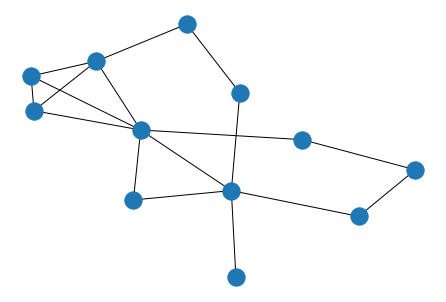

In [19]:
with open('files/small_network_nodes.csv', 'r') as nodecsv:
    nodereader = csv.reader(nodecsv)
    nodes = [n for n in nodereader][1:]

node_names = [n[0] for n in nodes]

with open('files/small_network_edges.csv', 'r') as edgecsv:
    edgereader = csv.reader(edgecsv)
    edges = [tuple(e) for e in edgereader][1:] # the [1:] is only if first line is heading

           
# now let us use networkx 
# graph creation of networkx object
G = nx.Graph()

G.add_nodes_from(node_names)
G.add_edges_from(edges)

nx.draw(G)
plt.plot()
print(nx.info(G))

# Wohooo we have a networkx object!! 


In [32]:
sex_dict = {}
age_dict = {}

for node in nodes:
    sex_dict[node[0]] = node[1]
    age_dict[node[0]] = node[2]

nx.set_node_attributes(G, sex_dict, 'sex')
nx.set_node_attributes(G, age_dict, 'age')

Plotting network with attributes and why it does not look good?

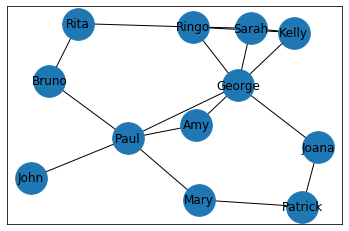

In [20]:
nx.draw_networkx(G, node_size=1000)

Maybe try colors 

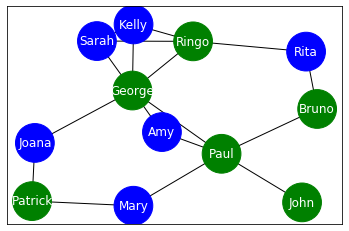

In [35]:
color_map = []
for n in G.nodes():
    if G.nodes[n]['sex'] == 'Female':
        color_map.append('blue')
    else: 
        color_map.append('green') 
        
nx.draw_networkx(G, node_size=1500, node_color=color_map, font_color='white')

In [38]:
print(nx.density(G))
print(nx.shortest_path(G, source="Kelly", target="John"))
print(nx.diameter(G)) #the longest of all shortest paths
print(nx.transitivity(G))
G.degree()


0.25757575757575757
['Kelly', 'George', 'Paul', 'John']
4
0.3488372093023256


DegreeView({'John': 1, 'Paul': 5, 'George': 6, 'Ringo': 4, 'Mary': 2, 'Amy': 2, 'Kelly': 3, 'Sarah': 3, 'Joana': 2, 'Patrick': 2, 'Bruno': 2, 'Rita': 2})

# Test yourself 

Make the same analysis with quarker network 
(see in files)